In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('laptop_prices.csv')
df.shape

(1275, 23)

In [4]:
df.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,ScreenH,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,1600,No,Yes,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,900,No,No,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,1080,No,No,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,1800,No,Yes,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,1600,No,Yes,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


In [5]:
df.isnull().sum()

Company                 0
Product                 0
TypeName                0
Inches                  0
Ram                     0
OS                      0
Weight                  0
Price_euros             0
Screen                  0
ScreenW                 0
ScreenH                 0
Touchscreen             0
IPSpanel                0
RetinaDisplay           0
CPU_company             0
CPU_freq                0
CPU_model               0
PrimaryStorage          0
SecondaryStorage        0
PrimaryStorageType      0
SecondaryStorageType    0
GPU_company             0
GPU_model               0
dtype: int64

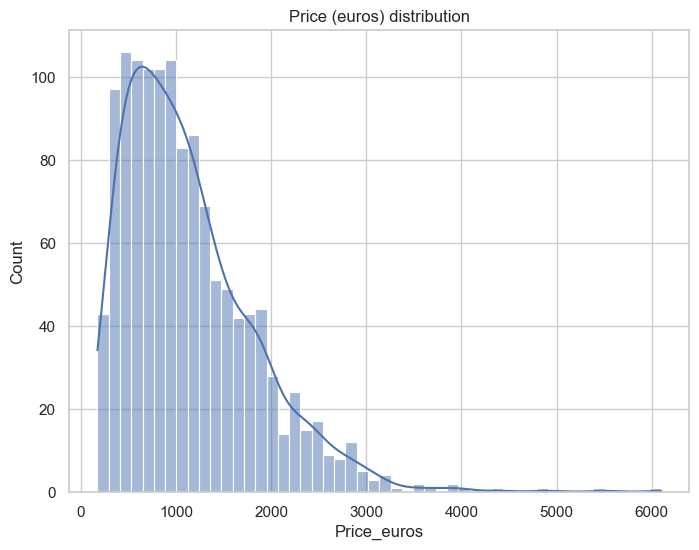

In [6]:
plt.figure(figsize = (8, 6))
sns.histplot(df['Price_euros'], bins = 50, kde = True)
plt.title("Price (euros) distribution")
plt.show()

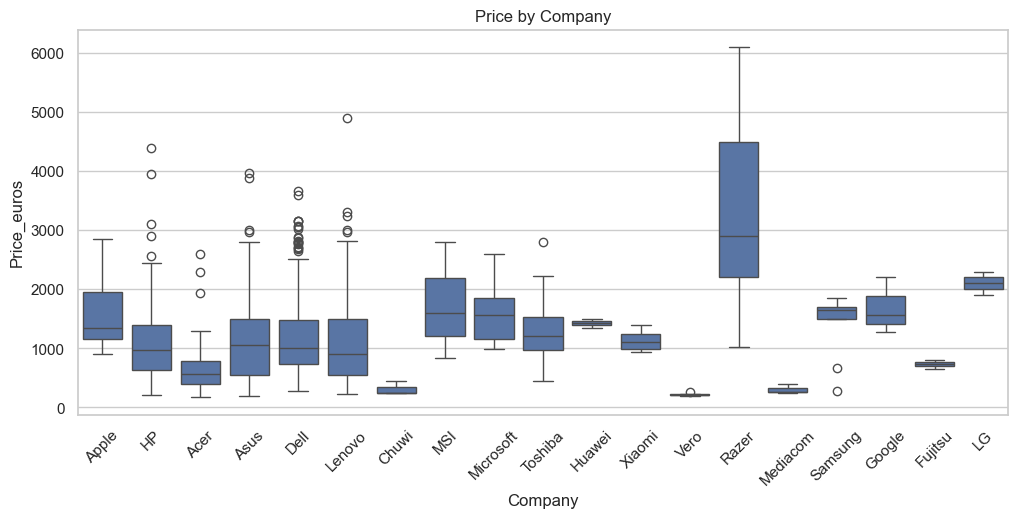

In [7]:
plt.figure(figsize = (12, 5))
sns.boxplot(x = 'Company', y = 'Price_euros', data = df)
plt.xticks(rotation = 45)
plt.title("Price by Company")
plt.show()

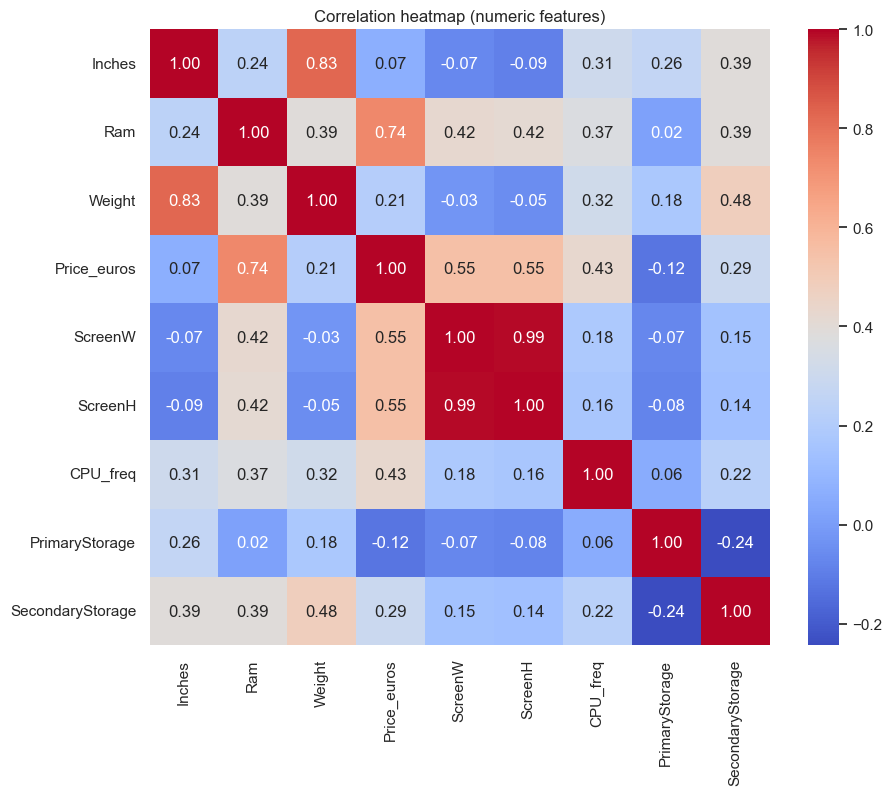

In [8]:
num_cols = df.select_dtypes(include = [np.number]).columns.tolist()
plt.figure(figsize = (10, 8))
sns.heatmap(df[num_cols].corr(), annot = True, fmt = ".2f", cmap = 'coolwarm')
plt.title("Correlation heatmap (numeric features)")
plt.show()

In [9]:
def compute_ppi(row):
    try:
        w = float(row['ScreenW'])
        h = float(row['ScreenH'])
        inches = float(row['Inches'])
        if inches > 0:
            return ((w**2 + h**2)**0.5) / inches
    except Exception:
        return np.nan
if set(['ScreenW', 'ScreenH', 'Inches']).issubset(df.columns):
    df['PPI'] = df.apply(compute_ppi, axis = 1)
else:
    df['PPI'] = np.nan     

In [10]:
for col in['Tochscreen', 'IPSpanel', 'RetinaDisplay', 'private']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().map({'yes':1, 'no':0, 'true':1, 'false':0, '1':1, '0':0}).fillna(0)

In [11]:
if df['Ram'].dtype == object:
    df['Ram'] = df['Ram'].str.extract(r'(\d+)').astype(float)
else:
    df['Ram'] = df['Ram'].astype(float)

In [12]:
if 'PrimaryStorage' in df.columns:
    df['PrimaryStorage'] = pd.to_numeric(df['PrimaryStorage'], errors = 'coerce').fillna(0).astype(int)
if 'SecondaryStorage' in df.columns:
    df['SecondaryStorage'] = pd.to_numeric(df['SecondaryStorage'], errors = 'coerce').fillna(0).astype(int)

In [13]:
if 'CPU_freq' in df.columns:
    df['CPU_freq'] = pd.to_numeric(df['CPU_freq'], errors = 'coerce')

In [14]:
if 'CPU_company' not in df.columns and 'CPU_model' in df.columns:
    df['CPU_company'] = df['CPU_model'].str.split().str[0]

In [15]:
df.head(5)

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,ScreenH,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model,PPI
0,Apple,MacBook Pro,Ultrabook,13.3,8.0,macOS,1.37,1339.69,Standard,2560,1600,No,1,1,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640,226.983005
1,Apple,Macbook Air,Ultrabook,13.3,8.0,macOS,1.34,898.94,Standard,1440,900,No,0,0,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000,127.677940
2,HP,250 G6,Notebook,15.6,8.0,No OS,1.86,575.00,Full HD,1920,1080,No,0,0,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620,141.211998
3,Apple,MacBook Pro,Ultrabook,15.4,16.0,macOS,1.83,2537.45,Standard,2880,1800,No,1,1,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455,220.534624
4,Apple,MacBook Pro,Ultrabook,13.3,8.0,macOS,1.37,1803.60,Standard,2560,1600,No,1,1,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650,226.983005


In [16]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Company,1275,19,Dell,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product,1275,618,XPS 13,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TypeName,1275,6,Notebook,707,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inches,1275.0,NaN,NaN,NaN,15.022902,1.42947,10.1,14.0,15.6,15.6,18.4
Ram,1275.0,NaN,NaN,NaN,8.440784,5.097809,2.0,4.0,8.0,8.0,64.0
OS,1275,9,Windows 10,1048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,1275.0,NaN,NaN,NaN,2.040525,0.669196,0.69,1.5,2.04,2.31,4.7
Price_euros,1275.0,NaN,NaN,NaN,1134.969059,700.752504,174.0,609.0,989.0,1496.5,6099.0
Screen,1275,4,Full HD,835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ScreenW,1275.0,NaN,NaN,NaN,1900.043922,493.346186,1366.0,1920.0,1920.0,1920.0,3840.0


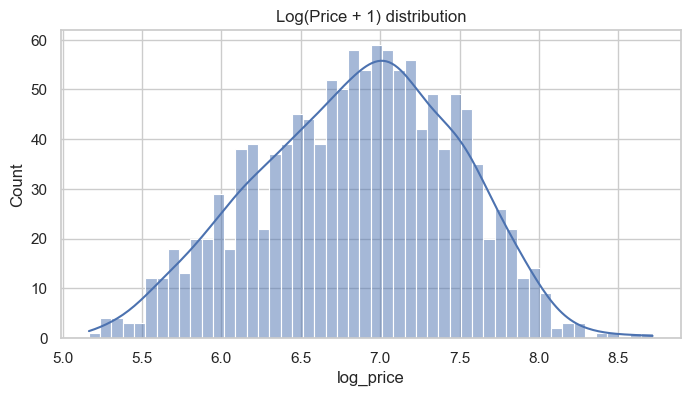

In [17]:
df['log_price'] = np.log1p(df['Price_euros'])
plt.figure(figsize = (8, 4))
sns.histplot(df['log_price'], bins = 50, kde = True)
plt.title("Log(Price + 1) distribution")
plt.show()

In [18]:
features = [
    'Company','TypeName','Inches','Ram','OS','Weight',
    'Screen','PPI','Touchscreen','IPSpanel','RetinaDisplay',
    'CPU_company','CPU_freq','PrimaryStorage','PrimaryStorageType',
    'SecondaryStorage','SecondaryStorageType','GPU_company'
]
features = [f for f in features if f in df.columns]
X = df[features].copy()
y = df['log_price'].copy()

In [19]:
for c in X.select_dtypes(include=[np.number]).columns:
    X[c] = X[c].fillna(X[c].median())
for c in X.select_dtypes(include=['object','category']).columns:
    X[c] = X[c].fillna('missing').astype(str)


In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train/Val shapes:", X_train.shape, X_val.shape)

Train/Val shapes: (1020, 18) (255, 18)


In [21]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

In [22]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])


In [23]:
print("Training RandomForestRegressor...")
model_pipeline.fit(X_train, y_train)

Training RandomForestRegressor...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Inches', 'Ram', 'Weight',
                                                   'PPI', 'IPSpanel',
                                                   'RetinaDisplay', 'CPU_freq',
                                                   'PrimaryStorage',
                                                   'SecondaryStorage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Company', 'TypeName', 'OS',
                                                   'Screen', 'Touchscreen',
                                                   'CPU_company',
                                                   'PrimaryStorageType',
                                                   'SecondaryStorageType',
                                                   'GPU_company'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

Validation RMSE: 276.66 euros
Validation MAE:  185.98 euros
Validation R2:   0.8458


E:\Harsha\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


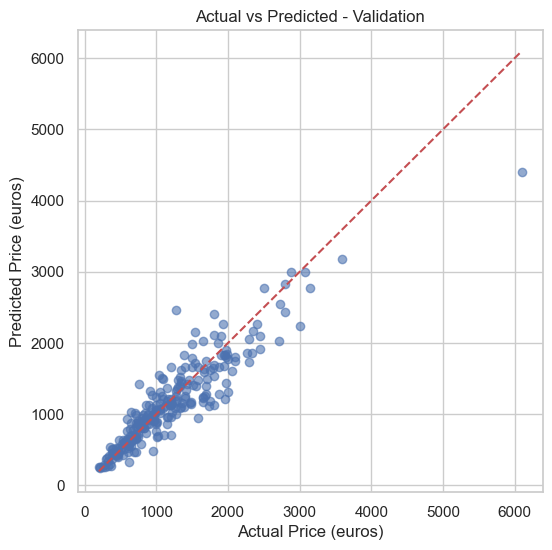

In [24]:
y_val_pred = model_pipeline.predict(X_val)
y_val_true = np.expm1(y_val)
y_val_pred_price = np.expm1(y_val_pred)

rmse = mean_squared_error(y_val_true, y_val_pred_price, squared=False)
mae = mean_absolute_error(y_val_true, y_val_pred_price)
r2 = r2_score(y_val_true, y_val_pred_price)

print(f"Validation RMSE: {rmse:.2f} euros")
print(f"Validation MAE:  {mae:.2f} euros")
print(f"Validation R2:   {r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred_price, alpha=0.6)
plt.plot([y_val_true.min(), y_val_true.max()], [y_val_true.min(), y_val_true.max()], 'r--')
plt.xlabel("Actual Price (euros)")
plt.ylabel("Predicted Price (euros)")
plt.title("Actual vs Predicted - Validation")
plt.show()

Top 20 feature importances:


Ram                       0.567359
CPU_freq                  0.095811
TypeName_Notebook         0.068989
Weight                    0.057171
PPI                       0.037180
PrimaryStorage            0.028414
Inches                    0.023573
Screen_Standard           0.014115
TypeName_Workstation      0.007969
IPSpanel                  0.007466
Company_HP                0.006409
OS_No OS                  0.005586
OS_Windows 10             0.005422
Screen_Full HD            0.004863
Company_Asus              0.004728
Company_Lenovo            0.004386
Company_Acer              0.004379
PrimaryStorageType_SSD    0.004164
CPU_company_Intel         0.004126
CPU_company_AMD           0.004017
dtype: float64

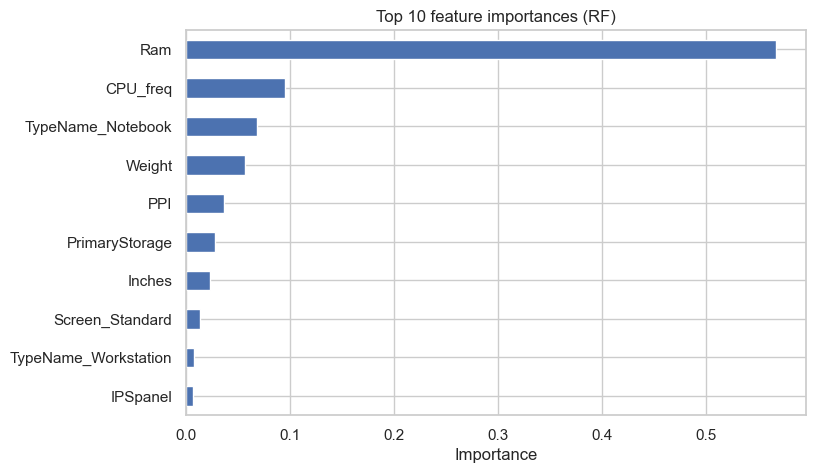

In [25]:
reg = model_pipeline.named_steps['regressor']
pre = model_pipeline.named_steps['preprocessor']

num_names = numeric_features
ohe = pre.named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = num_names + cat_names

importances = pd.Series(reg.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top 20 feature importances:")
display(importances.head(20))
plt.figure(figsize=(8,5))
importances.head(10)[::-1].plot(kind='barh')
plt.title("Top 10 feature importances (RF)")
plt.xlabel("Importance")
plt.show()

In [26]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}
grid = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
# grid.fit(X_train, y_train)   # uncomment to run
# print("Best params:", grid.best_params_, "Best score:", grid.best_score_)

In [27]:
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False

if XGB_AVAILABLE:
    xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1)
    pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb)])
    pipe_xgb.fit(X_train, y_train)
    y_val_pred_xgb = pipe_xgb.predict(X_val)
    y_val_pred_xgb_price = np.expm1(y_val_pred_xgb)
    rmse_xgb = mean_squared_error(y_val_true, y_val_pred_xgb_price, squared=False)
    print("XGBoost RMSE:", rmse_xgb)

In [28]:
OUT_MODEL = 'laptop_price_model.joblib'
joblib.dump(model_pipeline, OUT_MODEL)
print("Saved model to:", OUT_MODEL)

Saved model to: laptop_price_model.joblib


In [29]:
df_preds = df.copy()
df_preds['pred_log_price'] = model_pipeline.predict(df[features])
df_preds['pred_price_euros'] = np.expm1(df_preds['pred_log_price'])
display(df_preds[['Company','Product','Price_euros','pred_price_euros']].head())

df_preds[['Company','Product','Price_euros','pred_price_euros']].to_csv('laptop_price_predictions.csv', index=False)
print("Saved predictions to laptop_price_predictions.csv")


,Company,Product,Price_euros,pred_price_euros
0,Apple,MacBook Pro,1339.69,1304.340103
1,Apple,Macbook Air,898.94,991.959342
2,HP,250 G6,575.00,589.727480
3,Apple,MacBook Pro,2537.45,2464.565601
4,Apple,MacBook Pro,1803.60,1757.359378


Saved predictions to laptop_price_predictions.csv
